### Notebook for creating image to image autoencoders for sketches using pytorch

In [ ]:
### Author: Kushin Mukherjee

We're using python 3 plus the latest versions of all the packages listed below. Be sure to update before running this nb

In [4]:
### import package

import sys
from importlib import reload
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from IPython.display import clear_output
import svgpathtools
import os.path
from collections import Counter



import svg_rendering_helpers as srh

In [5]:

# directory & file hierarchy
proj_dir = os.path.abspath('..')
code_dir = os.getcwd()
plot_dir = os.path.join(proj_dir,'plots')
data_dir = os.path.join(proj_dir,'data')


if not os.path.exists(code_dir):
    os.makedirs(code_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# if svg_rendering_helpers.py not in sys.path:
#     sys.path.append(os.path.join(proj_dir,svg_rendering_helpers.py)) 

In [6]:
D = pd.read_csv(os.path.join(data_dir,'semantic_parts_annotated_data.csv'))

In [7]:
D.sketch_svg_string[0]

"[u'M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403,4.70702 38.10521,0 48,0c6.97504,0 29.82865,3.17135 34,-1c3.42085,-3.42085 -3.19012,-10.78518 -4,-12c-3.78389,-5.67584 -63.17292,-1 -79,-1', u'M92,61c0,18.89105 3,36.40812 3,55c0,1.58004 -0.75655,5 1,5', u'M169,60c0,20.0258 3,38.53083 3,57', u'M102,122c16.31683,10.87789 43.89528,-5 61,-5c0.74802,0 9,0 9,0c0,0 -1.47891,5.69728 -2,7c-4.79137,11.97843 -12.34671,43.34671 -20,51c-2.8003,2.8003 -21.92143,0 -26,0c-2.08325,0 -39.79187,-0.79187 -40,-1c-4.02358,-4.02358 13,-45.63903 13,-52c0,-2.36036 -0.54955,-3 2,-3', u'M83,174c0,17.6105 4,36.94202 4,53', u'M148,176c0,14.22848 5,31.9937 5,44', u'M172,120c3.28295,0 2.90737,5.90421 4,9c4.66601,13.22036 11.28855,72.28855 16,77', u'M103,179c3.79513,0 8.1022,13 12,13']"

In [8]:
def listify(string):
    split_list = string.split("'")
    l=[", u","[u","]"]
    out = [x for x in split_list if x not in l]
    return(out)
    

In [9]:
D.sketch_svg_string = D.sketch_svg_string.apply(listify)

In [10]:
len(D.sketch_svg_string[0])

8

In [11]:
unique_cats = np.unique(D.category)
unique_cats

array(['bird', 'car', 'chair', 'dog'], dtype=object)

In [12]:
#Creating a spline-level df where the modal label is set as the 'true' label for any given spline
spline_df= D.groupby('spline_id').agg(lambda x: Counter(x).most_common(1)[0][0])
spline_df.reset_index(level=0, inplace=True)

##Creating a stroke-level dataframe that takes the mode value of annotation for its children splines to set as its
##label value

from collections import Counter


from collections import OrderedDict
stroke_svgs=OrderedDict()
for category in unique_cats:
    DS=D[D['category']==category]
    for sketch in np.unique(DS['sketch_id']):
        DSS=DS[DS['sketch_id']==sketch]
        for stroke in np.unique(DSS['stroke_num']):
            DSA=DSS[DSS['stroke_num']==stroke]
            DSA=DSA.reset_index()
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke]

            
            
stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')    
stroke_group_data= D.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0])
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category','outcome']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True)
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"})


In [13]:
D.sketch_svg_string[0]

['M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403,4.70702 38.10521,0 48,0c6.97504,0 29.82865,3.17135 34,-1c3.42085,-3.42085 -3.19012,-10.78518 -4,-12c-3.78389,-5.67584 -63.17292,-1 -79,-1',
 'M92,61c0,18.89105 3,36.40812 3,55c0,1.58004 -0.75655,5 1,5',
 'M169,60c0,20.0258 3,38.53083 3,57',
 'M102,122c16.31683,10.87789 43.89528,-5 61,-5c0.74802,0 9,0 9,0c0,0 -1.47891,5.69728 -2,7c-4.79137,11.97843 -12.34671,43.34671 -20,51c-2.8003,2.8003 -21.92143,0 -26,0c-2.08325,0 -39.79187,-0.79187 -40,-1c-4.02358,-4.02358 13,-45.63903 13,-52c0,-2.36036 -0.54955,-3 2,-3',
 'M83,174c0,17.6105 4,36.94202 4,53',
 'M148,176c0,14.22848 5,31.9937 5,44',
 'M172,120c3.28295,0 2.90737,5.90421 4,9c4.66601,13.22036 11.28855,72.28855 16,77',
 'M103,179c3.79513,0 8.1022,13 12,13']

In [14]:
D_birds = stroke_df[stroke_df['category']=='bird']

In [15]:
D_bj = D_birds[D_birds['target']=='bluejay']

In [25]:
D_tt = D_birds[D_birds['target']=='tomtit']

In [31]:
reload(srh)
really_run = True

if really_run==True:

    for sketch in D_bj.sketch_id.unique():
        this_sketch = D_bj.query('sketch_id == @sketch')
        svgs = list(this_sketch.svg)
        srh.render_svg(svgs,out_dir ="train_bj", base_dir=plot_dir,out_fname='{}.svg'.format(sketch))


In [32]:
reload(srh)
really_run = True

if really_run==True:

    for sketch in D_tt.sketch_id.unique():
        this_sketch = D_tt.query('sketch_id == @sketch')
        svgs = list(this_sketch.svg)
        srh.render_svg(svgs,out_dir="test_tt" ,base_dir=plot_dir,out_fname='{}.svg'.format(sketch))


In [33]:
### Create path to lesioned svgs and convert to png for feature extraction
really_run = True

if really_run==True:
    svg_paths= srh.generate_svg_path_list(os.path.join(plot_dir,'train_bj'))
    srh.svg_to_png(svg_paths,out_dir="train_bj_png",base_dir=plot_dir)

convert /Users/kushin/Documents/Github/UW_sketch_work/plots/train_bj/2721-f28245be-a3ac-425e-9538-5c0803980807_23.svg /Users/kushin/Documents/Github/UW_sketch_work/plots/train_bj_png/2721-f28245be-a3ac-425e-9538-5c0803980807_23.png


In [34]:
### Create path to lesioned svgs and convert to png for feature extraction
really_run = True

if really_run==True:
    svg_paths= srh.generate_svg_path_list(os.path.join(plot_dir,'test_tt'))
    srh.svg_to_png(svg_paths,out_dir="test_tt_png",base_dir=plot_dir)

convert /Users/kushin/Documents/Github/UW_sketch_work/plots/test_tt/8297-39d66207-4fb6-430c-8e2b-4f95213b6a55_30.svg /Users/kushin/Documents/Github/UW_sketch_work/plots/test_tt_png/8297-39d66207-4fb6-430c-8e2b-4f95213b6a55_30.png


In [67]:
from torchvision.utils import save_image
from torchvision import datasets
import torchvision
from torch.autograd import Variable

In [61]:
#train_set = os.path.join(plot_dir, "train_bj_png")


train_set = datasets.ImageFolder(os.path.join(plot_dir), transform=torchvision.transforms.ToTensor())

In [62]:
dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)

In [74]:
test_set = datasets.ImageFolder(os.path.join(plot_dir), transform=torchvision.transforms.ToTensor())

In [75]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)

In [63]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(16,6,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,3,kernel_size=5),
            nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [64]:
num_epochs = 5 #you can go for more epochs, I am using a mac
batch_size = 128

In [65]:
model = Autoencoder().cpu()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

In [120]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
  #  print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data()))

In [70]:
model()

<bound method Module.parameters of Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
)>

In [121]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [200]:
ims= []
for data in dataloader:
    for d in data:
        img, _ = data
        p_img = model(img).detach()
        for p in p_img:
            ims.append(np.array(p).transpose(1,2,0))

In [201]:
len(d)

25

In [202]:
ims[0].shape

(300, 300, 3)

In [203]:
ims[25].shape

(300, 300, 3)

In [204]:
ims[0][0].shape

(300, 3)

In [205]:
ims[0].shape

(300, 300, 3)

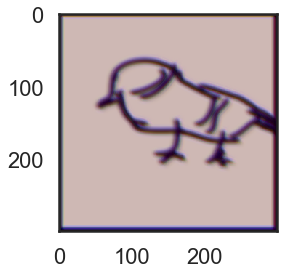

In [207]:
plt.imshow(ims[32])